# Final model

### Resources

- https://geemap.org/notebooks/46_local_rf_training/

## Setup

In [1]:
from google.colab import drive
import os
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import ee
import geemap
from geemap import ml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/land_cover_classification_kaza

/content/drive/MyDrive/land_cover_classification_kaza


In [4]:
user_id = 'ee-alexvmt'
asset_name = 'mufunta_random_forest'

In [5]:
ee.Authenticate()
ee.Initialize(project=user_id)

## Load train and test set

In [6]:
train = pd.read_csv('data/train.csv')
train

,B11_Q1,B11_Q2,B11_Q3,B11_Q4,B12_Q1,B12_Q2,B12_Q3,B12_Q4,B2_Q1,B2_Q2,...,B8A_Q2,B8A_Q3,B8A_Q4,B8_Q1,B8_Q2,B8_Q3,B8_Q4,LC_Nr,LC_Out,Landcover
0,1676.5,1855.5,2356.0,2994.0,843.5,1048.5,1518.0,2345.0,328.0,432.0,...,2232.0,2113.0,2507.0,2528.0,2307.0,2040.0,2296.0,7,Forest,Forest
1,1682.0,1729.5,2152.0,2983.0,836.0,994.5,1518.0,1958.0,263.0,320.0,...,2039.0,1869.0,2819.0,2348.0,1766.0,1676.0,2536.0,7,Forest,Forest
2,1826.5,2046.0,2157.0,3445.0,897.5,1126.0,1461.0,2480.0,258.5,337.5,...,2223.0,1905.0,3083.0,2279.0,1875.0,1722.0,2718.0,7,Forest,Forest
3,1757.5,1739.0,2058.0,2498.0,938.5,995.0,1398.0,1529.0,274.0,296.0,...,1926.0,1816.0,2774.0,1978.0,1748.0,1691.0,2429.0,7,Forest,Forest
4,1817.0,1957.5,2369.0,3147.0,889.0,1101.0,1433.0,2632.0,288.5,352.0,...,2416.5,2213.0,2548.0,2636.0,2189.0,2008.0,2336.0,7,Forest,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,2955.5,2885.5,3179.0,3912.0,2391.0,2294.0,2725.0,3652.0,626.0,692.0,...,2232.5,2363.0,2859.0,3005.0,2158.0,2340.0,2684.0,3,Built-up,Built up
3301,2932.0,3434.0,3763.0,4097.0,2127.0,2967.5,3378.0,3772.0,953.0,1104.0,...,2731.0,2780.0,3324.0,2819.0,2598.0,2600.0,2994.0,3,Built-up,Built up
3302,2685.0,3169.0,3626.0,3953.5,2078.0,2625.5,3170.0,3640.0,1102.0,1127.0,...,2727.5,2756.0,2872.0,2880.0,2786.5,2640.0,2758.0,3,Built-up,Built up
3303,1352.0,3222.0,3534.0,3774.0,704.0,3107.5,3353.0,3469.0,281.0,1115.0,...,2117.5,2460.0,2566.0,1950.0,2310.0,2626.0,2584.0,3,Built-up,Built up


In [7]:
X_train = train.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_train

,B11_Q1,B11_Q2,B11_Q3,B11_Q4,B12_Q1,B12_Q2,B12_Q3,B12_Q4,B2_Q1,B2_Q2,...,B7_Q3,B7_Q4,B8A_Q1,B8A_Q2,B8A_Q3,B8A_Q4,B8_Q1,B8_Q2,B8_Q3,B8_Q4
0,1676.5,1855.5,2356.0,2994.0,843.5,1048.5,1518.0,2345.0,328.0,432.0,...,1808.0,2249.0,2652.0,2232.0,2113.0,2507.0,2528.0,2307.0,2040.0,2296.0
1,1682.0,1729.5,2152.0,2983.0,836.0,994.5,1518.0,1958.0,263.0,320.0,...,1606.0,2402.0,2659.5,2039.0,1869.0,2819.0,2348.0,1766.0,1676.0,2536.0
2,1826.5,2046.0,2157.0,3445.0,897.5,1126.0,1461.0,2480.0,258.5,337.5,...,1637.0,2519.0,2720.5,2223.0,1905.0,3083.0,2279.0,1875.0,1722.0,2718.0
3,1757.5,1739.0,2058.0,2498.0,938.5,995.0,1398.0,1529.0,274.0,296.0,...,1570.0,2425.0,2281.5,1926.0,1816.0,2774.0,1978.0,1748.0,1691.0,2429.0
4,1817.0,1957.5,2369.0,3147.0,889.0,1101.0,1433.0,2632.0,288.5,352.0,...,1894.0,2229.0,3005.0,2416.5,2213.0,2548.0,2636.0,2189.0,2008.0,2336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,2955.5,2885.5,3179.0,3912.0,2391.0,2294.0,2725.0,3652.0,626.0,692.0,...,2068.0,2657.0,3067.0,2232.5,2363.0,2859.0,3005.0,2158.0,2340.0,2684.0
3301,2932.0,3434.0,3763.0,4097.0,2127.0,2967.5,3378.0,3772.0,953.0,1104.0,...,2531.0,3078.0,2997.5,2731.0,2780.0,3324.0,2819.0,2598.0,2600.0,2994.0
3302,2685.0,3169.0,3626.0,3953.5,2078.0,2625.5,3170.0,3640.0,1102.0,1127.0,...,2485.0,2719.5,3349.0,2727.5,2756.0,2872.0,2880.0,2786.5,2640.0,2758.0
3303,1352.0,3222.0,3534.0,3774.0,704.0,3107.5,3353.0,3469.0,281.0,1115.0,...,2177.0,2297.0,2101.0,2117.5,2460.0,2566.0,1950.0,2310.0,2626.0,2584.0


In [8]:
y_train = train['LC_Nr']
y_train

0       7
1       7
2       7
3       7
4       7
       ..
3300    3
3301    3
3302    3
3303    3
3304    3
Name: LC_Nr, Length: 3305, dtype: int64

In [9]:
test = pd.read_csv('data/test.csv')
test

,B11_Q1,B11_Q2,B11_Q3,B11_Q4,B12_Q1,B12_Q2,B12_Q3,B12_Q4,B2_Q1,B2_Q2,...,B8A_Q2,B8A_Q3,B8A_Q4,B8_Q1,B8_Q2,B8_Q3,B8_Q4,LC_Nr,LC_Out,Landcover
0,1443.0,1427.0,1542.0,1789.0,647.0,693.0,853.0,995.0,229.0,256.0,...,1832.0,1742.0,2361.0,2032.0,1666.0,1591.0,2126.0,7,Forest,Forest
1,1424.5,1320.0,1563.0,1675.0,607.5,606.0,833.0,878.0,223.0,240.0,...,2024.0,1895.0,2399.0,2236.5,1987.0,1838.0,2156.0,7,Forest,Forest
2,1717.0,1808.5,1957.0,3563.0,873.5,1022.0,1439.0,2501.0,256.0,313.0,...,2017.5,1859.0,3133.0,2027.0,1759.0,1624.0,2840.0,7,Forest,Forest
3,1606.0,1688.5,2052.0,2454.0,749.0,873.0,1207.0,1798.0,266.5,298.0,...,2093.0,1966.0,2698.0,2523.0,2068.0,1890.0,2620.0,7,Forest,Forest
4,1681.0,1837.5,1990.0,2658.5,910.0,1039.5,1228.0,1887.5,305.0,343.0,...,2080.0,2060.0,2702.5,2075.0,1753.0,1788.0,2296.0,7,Forest,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78316,3189.0,2890.5,2844.0,3182.0,2972.5,2846.5,2848.0,3276.0,1312.0,976.0,...,2176.0,2073.0,2316.0,2167.0,1917.0,1782.0,2022.0,3,Built-up,Built up
78317,1389.0,3557.5,3832.0,3994.0,735.0,3635.5,3899.0,3955.0,285.0,1111.0,...,2483.0,2696.0,2961.0,1954.0,2252.0,2532.0,2752.0,3,Built-up,Built up
78318,1376.0,3709.0,3940.5,3963.0,707.0,3779.5,3886.5,3880.0,290.0,1274.0,...,2571.5,2709.0,2693.0,1830.0,2556.0,2725.0,2554.0,3,Built-up,Built up
78319,3904.0,3587.5,4037.0,4515.0,3472.0,3207.0,4012.0,4244.0,1668.0,1237.0,...,2812.5,2577.5,3091.0,3208.0,2589.5,2501.0,2930.0,3,Built-up,Built up


In [10]:
X_test = test.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_test

,B11_Q1,B11_Q2,B11_Q3,B11_Q4,B12_Q1,B12_Q2,B12_Q3,B12_Q4,B2_Q1,B2_Q2,...,B7_Q3,B7_Q4,B8A_Q1,B8A_Q2,B8A_Q3,B8A_Q4,B8_Q1,B8_Q2,B8_Q3,B8_Q4
0,1443.0,1427.0,1542.0,1789.0,647.0,693.0,853.0,995.0,229.0,256.0,...,1546.833333,2113.0,2266.0,1832.0,1742.0,2361.0,2032.0,1666.0,1591.0,2126.0
1,1424.5,1320.0,1563.0,1675.0,607.5,606.0,833.0,878.0,223.0,240.0,...,1620.000000,2118.0,2476.5,2024.0,1895.0,2399.0,2236.5,1987.0,1838.0,2156.0
2,1717.0,1808.5,1957.0,3563.0,873.5,1022.0,1439.0,2501.0,256.0,313.0,...,1586.000000,2684.0,2435.0,2017.5,1859.0,3133.0,2027.0,1759.0,1624.0,2840.0
3,1606.0,1688.5,2052.0,2454.0,749.0,873.0,1207.0,1798.0,266.5,298.0,...,1709.000000,2384.0,2658.5,2093.0,1966.0,2698.0,2523.0,2068.0,1890.0,2620.0
4,1681.0,1837.5,1990.0,2658.5,910.0,1039.5,1228.0,1887.5,305.0,343.0,...,1821.000000,2340.0,2439.0,2080.0,2060.0,2702.5,2075.0,1753.0,1788.0,2296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78316,3189.0,2890.5,2844.0,3182.0,2972.5,2846.5,2848.0,3276.0,1312.0,976.0,...,2034.000000,2224.0,2403.0,2176.0,2073.0,2316.0,2167.0,1917.0,1782.0,2022.0
78317,1389.0,3557.5,3832.0,3994.0,735.0,3635.5,3899.0,3955.0,285.0,1111.0,...,2425.000000,2653.0,2042.0,2483.0,2696.0,2961.0,1954.0,2252.0,2532.0,2752.0
78318,1376.0,3709.0,3940.5,3963.0,707.0,3779.5,3886.5,3880.0,290.0,1274.0,...,2421.500000,2414.0,2165.0,2571.5,2709.0,2693.0,1830.0,2556.0,2725.0,2554.0
78319,3904.0,3587.5,4037.0,4515.0,3472.0,3207.0,4012.0,4244.0,1668.0,1237.0,...,2196.500000,2586.0,3212.0,2812.5,2577.5,3091.0,3208.0,2589.5,2501.0,2930.0


In [11]:
y_test = test['LC_Nr']
y_test

0        7
1        7
2        7
3        7
4        7
        ..
78316    3
78317    3
78318    3
78319    3
78320    3
Name: LC_Nr, Length: 78321, dtype: int64

## Train random forest with default hyperparameters

In [12]:
rf_default = RandomForestClassifier()

In [13]:
rf_default.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_train_pred = rf_default.predict(X_train)
y_test_pred = rf_default.predict(X_test)

## Evaluation

### Train set classification metrics

In [15]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [16]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [17]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [18]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [19]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [20]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

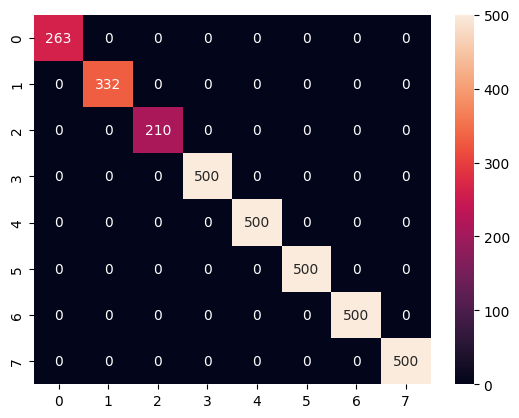

In [21]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [22]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.9289


In [23]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7802


In [24]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.9310


In [25]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.8228


In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.90      0.99      0.94       113
           2       0.22      0.96      0.35       143
           3       0.71      0.89      0.79        90
           4       1.00      0.94      0.97     17628
           5       0.74      0.93      0.83      3248
           6       0.72      0.86      0.78      8266
           7       0.97      0.93      0.95     35183
           8       0.99      0.95      0.97     13650

    accuracy                           0.93     78321
   macro avg       0.78      0.93      0.82     78321
weighted avg       0.94      0.93      0.93     78321



In [27]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  112,     0,     0,     0,     0,     0,     0,     1],
       [    0,   137,     0,     6,     0,     0,     0,     0],
       [    0,     6,    80,     2,     1,     1,     0,     0],
       [    0,   436,    28, 16606,   228,   174,   130,    26],
       [    0,    13,     0,    11,  3012,   103,     0,   109],
       [    0,    37,     3,    36,   266,  7098,   774,    52],
       [    0,     0,     0,     0,    22,  2443, 32712,     6],
       [   13,     0,     1,    18,   521,    87,    14, 12996]])

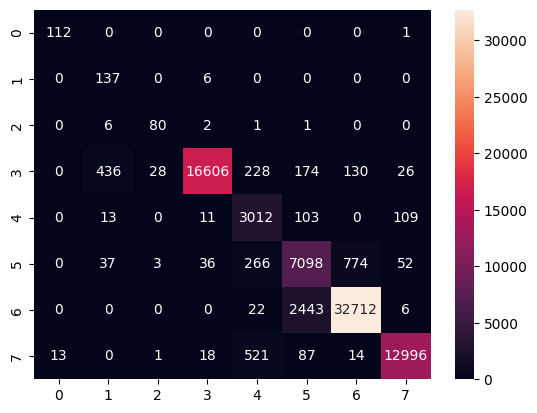

In [28]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Train random forest with optimized hyperparameters

Get optimized hyperparameters from notebook called `optimization.ipynb`.

In [29]:
rf_optimized = RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=5,
                           min_samples_split=4, n_estimators=512, n_jobs=1,
                           random_state=1, warm_start=True)

In [30]:
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=5,
                       min_samples_split=4, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)

In [31]:
y_train_pred = rf_optimized.predict(X_train)
y_test_pred = rf_optimized.predict(X_test)

## Evaluation

### Train set classification metrics

In [32]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [33]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [34]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [35]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [36]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [37]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

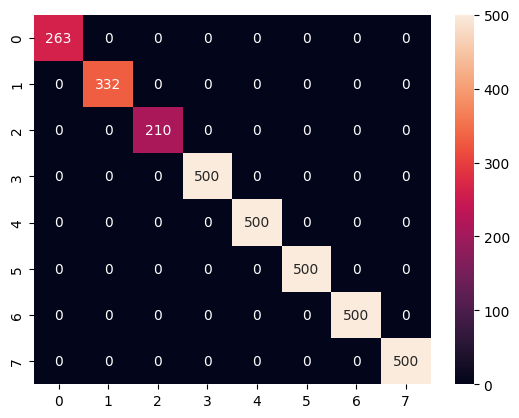

In [38]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [39]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.9349


In [40]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.8070


In [41]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.9410


In [42]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.8485


In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95       113
           2       0.29      0.97      0.45       143
           3       0.80      0.91      0.85        90
           4       1.00      0.95      0.97     17628
           5       0.77      0.94      0.85      3248
           6       0.73      0.87      0.79      8266
           7       0.97      0.93      0.95     35183
           8       0.99      0.96      0.97     13650

    accuracy                           0.93     78321
   macro avg       0.81      0.94      0.85     78321
weighted avg       0.95      0.93      0.94     78321



In [44]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  113,     0,     0,     0,     0,     0,     0,     0],
       [    0,   138,     0,     5,     0,     0,     0,     0],
       [    0,     5,    82,     2,     0,     1,     0,     0],
       [    0,   289,    16, 16779,   202,   189,   127,    26],
       [    0,    10,     0,     9,  3064,    80,     0,    85],
       [    0,    35,     2,    35,   245,  7168,   735,    46],
       [    0,     0,     0,     0,     9,  2334, 32831,     9],
       [   11,     0,     2,    19,   481,    72,    14, 13051]])

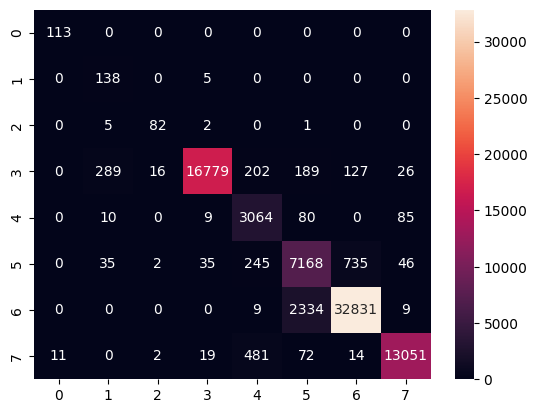

In [45]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Feature importance

In [46]:
def get_feature_importances(column_names, feature_importances):

  importances = pd.DataFrame(list(zip(column_names, feature_importances)), columns=['Feature', 'Importance'])
  importances = importances.sort_values('Importance', ascending=False)

  return importances

In [47]:
def plot_feature_importances(feature_importances, model_name):

  plt.figure(figsize=(10,6))

  plt.bar(feature_importances['Feature'], feature_importances['Importance'])
  plt.xticks(rotation=90)

  plt.title(f'Feature Importances - {model_name}')

  plt.tight_layout()
  plt.show()

### RF default

In [48]:
rf_default_importances = get_feature_importances(X_train.columns, rf_default.feature_importances_)
rf_default_importances.head(10)

,Feature,Importance
3,B11_Q4,0.049323
5,B12_Q2,0.048048
1,B11_Q2,0.045235
35,B8A_Q4,0.039458
19,B4_Q4,0.037717
17,B4_Q2,0.036583
39,B8_Q4,0.035924
9,B2_Q2,0.034225
23,B5_Q4,0.031024
32,B8A_Q1,0.030559


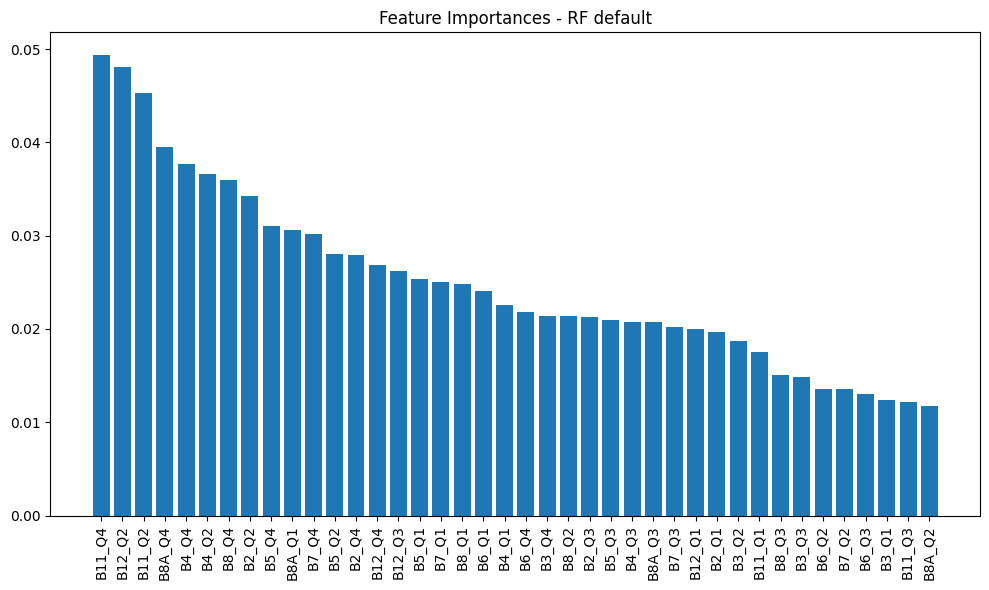

In [49]:
plot_feature_importances(rf_default_importances, 'RF default')

### RF optimized

In [50]:
rf_optimized_importances = get_feature_importances(X_train.columns, rf_optimized.feature_importances_)
rf_optimized_importances.head(10)

,Feature,Importance
23,B5_Q4,0.049506
19,B4_Q4,0.047877
5,B12_Q2,0.045360
35,B8A_Q4,0.039839
15,B3_Q4,0.039756
31,B7_Q4,0.036800
17,B4_Q2,0.036029
9,B2_Q2,0.034739
1,B11_Q2,0.032511
3,B11_Q4,0.031696


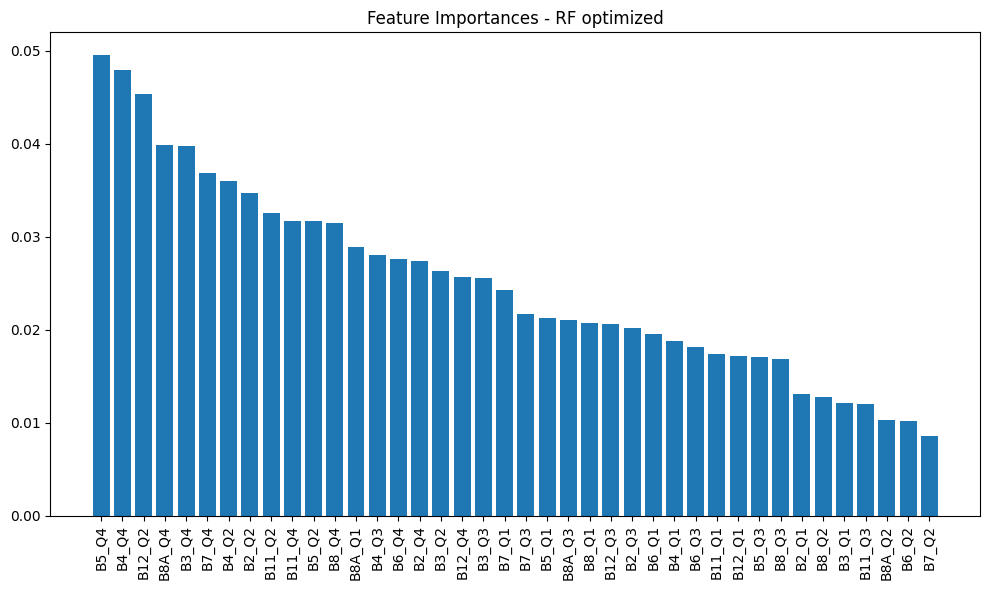

In [51]:
plot_feature_importances(rf_optimized_importances, 'RF optimized')

### Compare feature importances

In [52]:
rf_default_importances = rf_default_importances.rename(columns={'Importance': 'Importance - RF default'})
rf_optimized_importances = rf_optimized_importances.rename(columns={'Importance': 'Importance - RF optimized'})
importances = pd.merge(rf_default_importances, rf_optimized_importances, how='inner', on='Feature')
importances.head(10)

,Feature,Importance - RF default,Importance - RF optimized
0,B11_Q4,0.049323,0.031696
1,B12_Q2,0.048048,0.045360
2,B11_Q2,0.045235,0.032511
3,B8A_Q4,0.039458,0.039839
4,B4_Q4,0.037717,0.047877
5,B4_Q2,0.036583,0.036029
6,B8_Q4,0.035924,0.031424
7,B2_Q2,0.034225,0.034739
8,B5_Q4,0.031024,0.049506
9,B8A_Q1,0.030559,0.028935


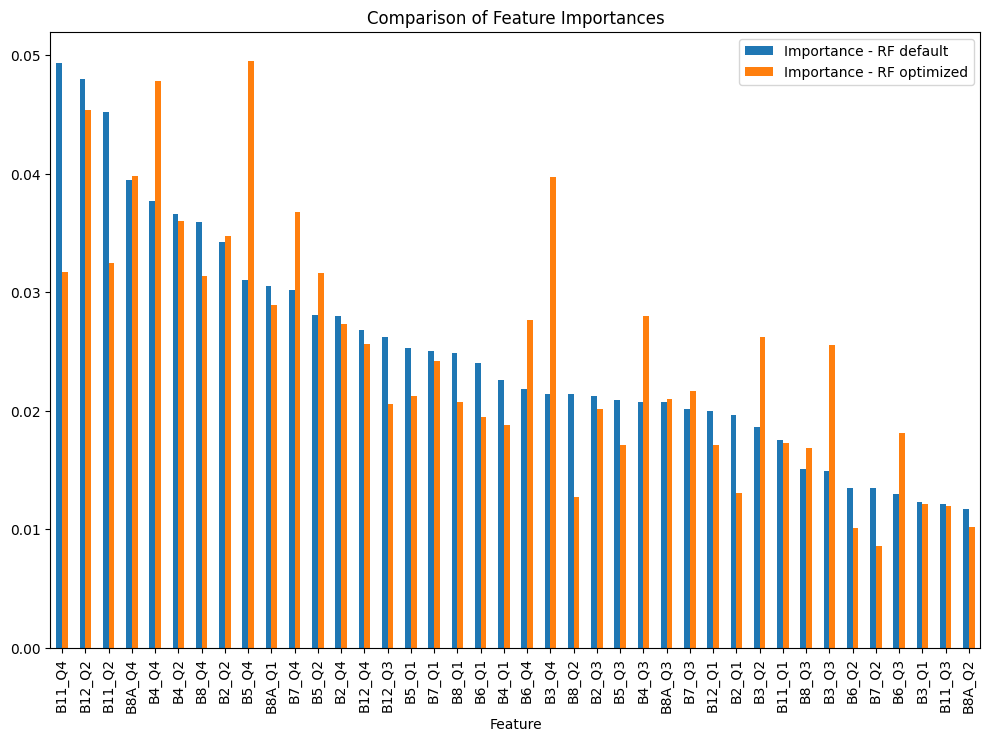

In [53]:
importances.plot(x='Feature', y=['Importance - RF default', 'Importance - RF optimized'], kind='bar', rot=90, title='Comparison of Feature Importances', figsize=(12,8))
plt.show()

## Permutation importance

In [54]:
def get_permutation_importances(model, X_train, y_train, X_test, y_test):

  # set parameters
  scoring = 'f1_macro'
  n_repeats = 5
  n_jobs = -1
  seed = 42
  max_samples = 0.3

  print('Getting permutation importances for train set...')
  train_results = permutation_importance(rf_default, X_train, y_train, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=seed)

  print('Getting permutation importances for test set...')
  test_results = permutation_importance(rf_default, X_test, y_test, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=seed, max_samples=max_samples)

  sorted_importances_idx = train_results.importances_mean.argsort()
  feature_names = X_train.columns
  train_importances = pd.DataFrame(train_results.importances[sorted_importances_idx].T, columns=feature_names[sorted_importances_idx])
  test_importances = pd.DataFrame(test_results.importances[sorted_importances_idx].T, columns=feature_names[sorted_importances_idx])

  return train_importances, test_importances

In [55]:
def plot_permutation_importances(train_importances, test_importances):

  for name, importances in zip(['train', 'test'], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(8,16))
    ax.set_title(f'Permutation importances ({name} set)')
    ax.set_xlabel('Decrease in f1_macro')
    ax.axvline(x=0, color='k', linestyle='--')
    ax.figure.tight_layout()

### RF default

Getting permutation importances for train set...
Getting permutation importances for test set...
CPU times: user 6.21 s, sys: 862 ms, total: 7.07 s
Wall time: 1min 26s


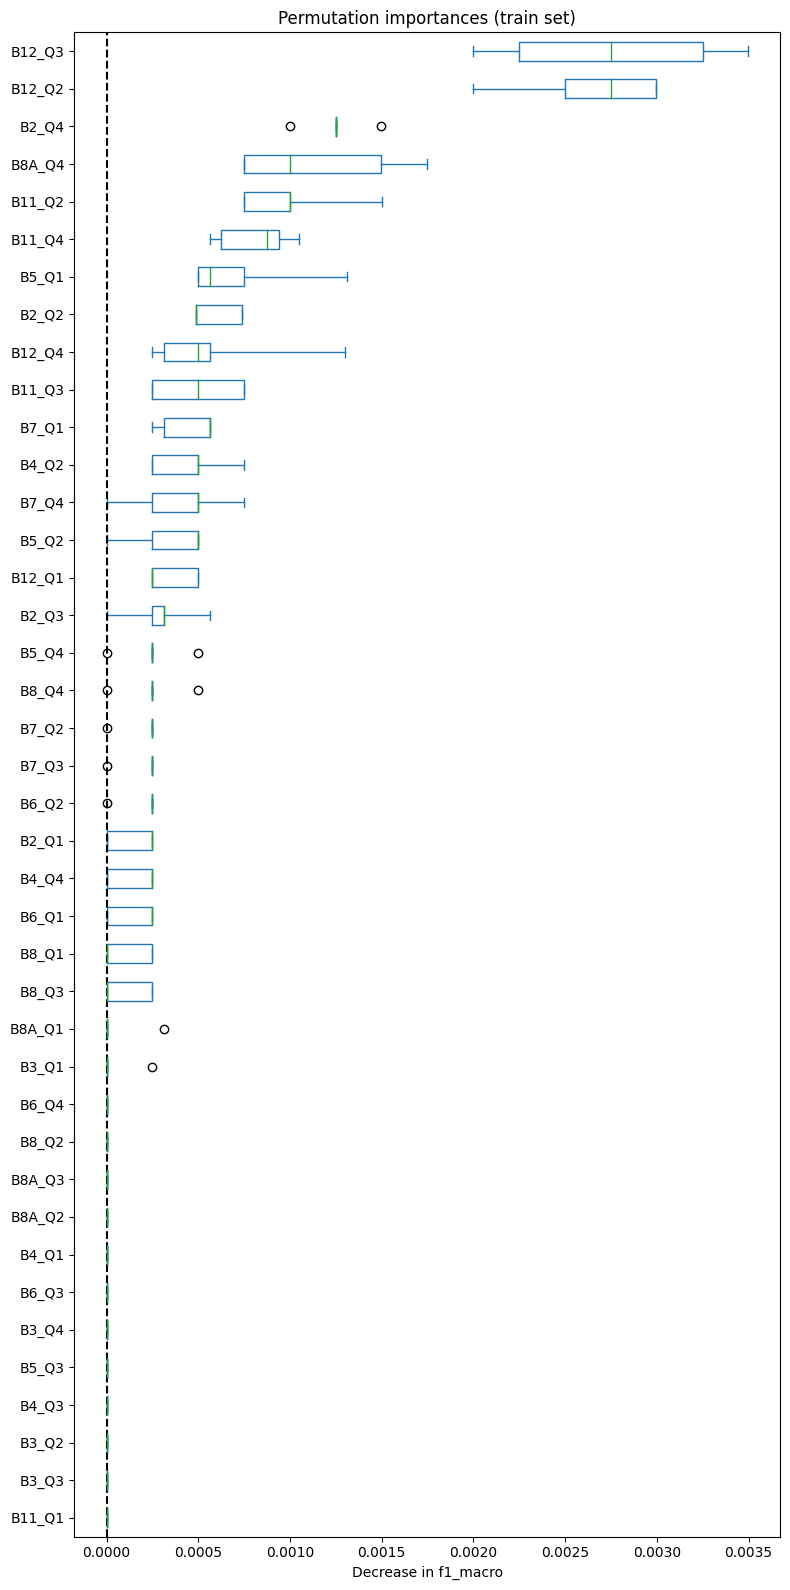

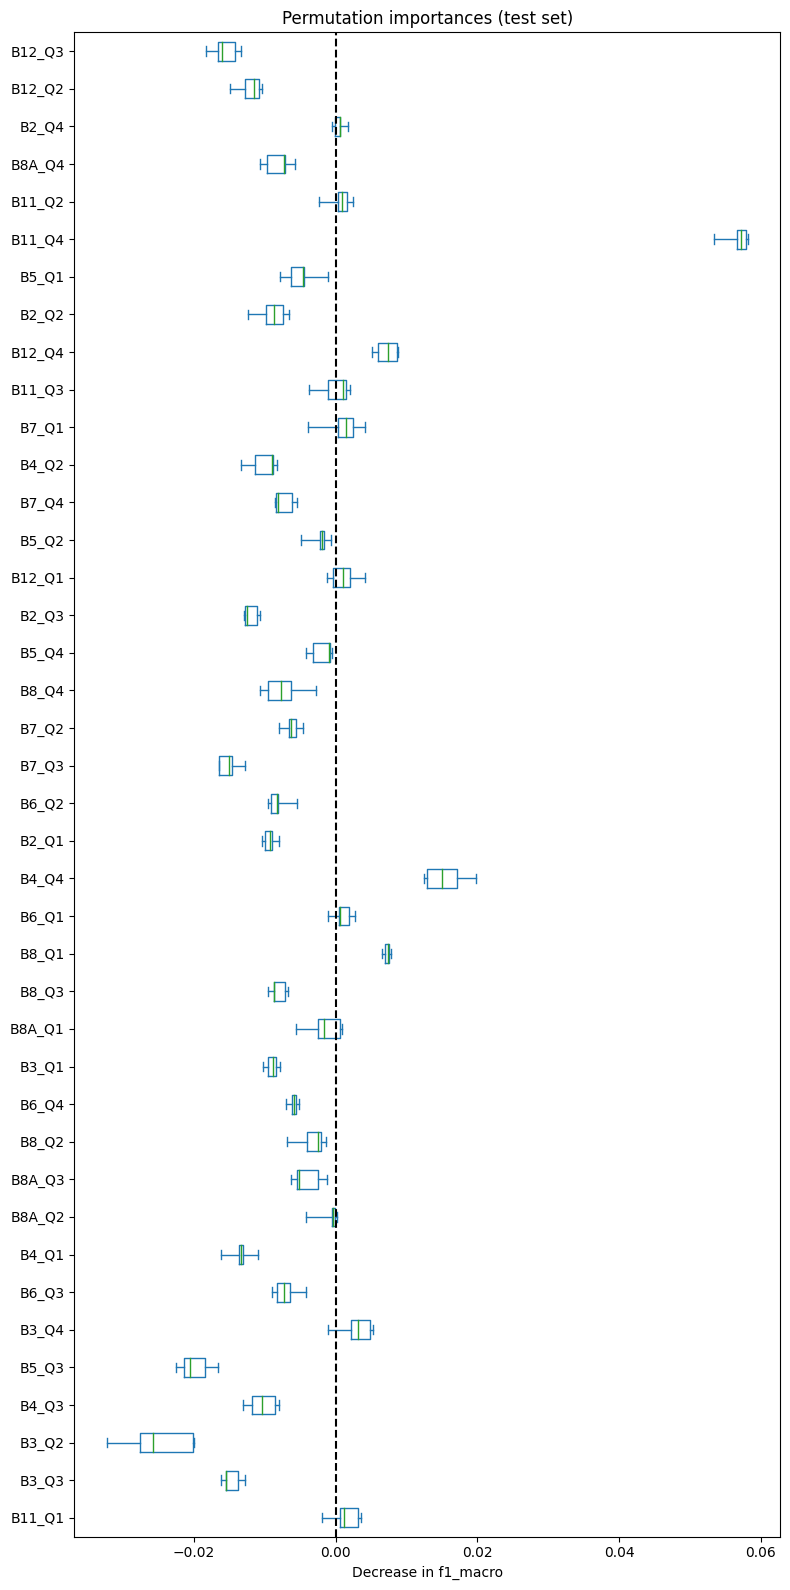

In [56]:
%%time
rf_default_train_importances, rf_default_test_importances = get_permutation_importances(rf_default, X_train, y_train, X_test, y_test)
plot_permutation_importances(rf_default_train_importances, rf_default_test_importances)

### RF optimized

Getting permutation importances for train set...
Getting permutation importances for test set...
CPU times: user 6.36 s, sys: 567 ms, total: 6.92 s
Wall time: 1min 21s


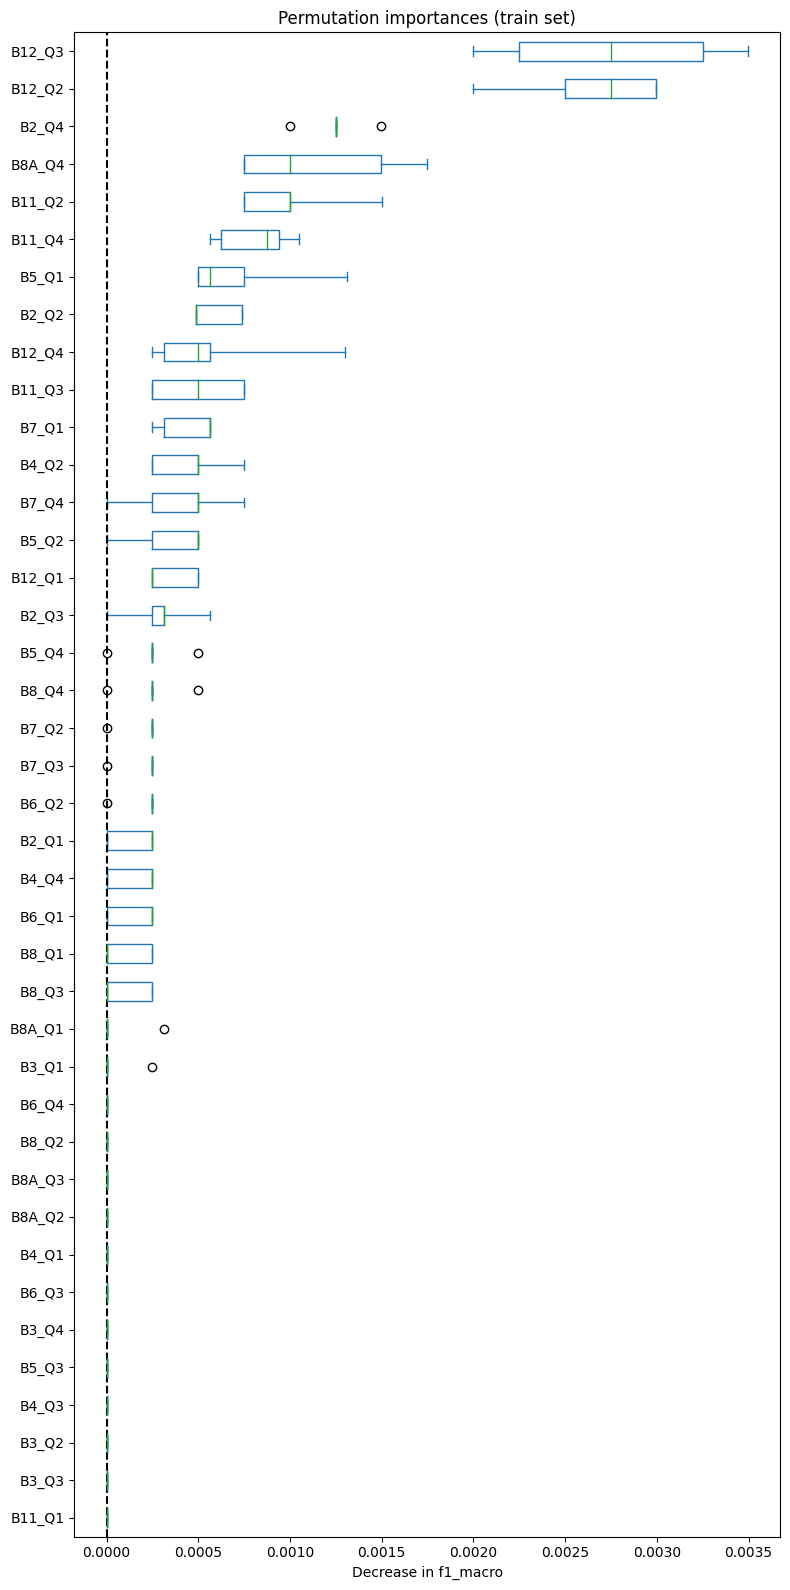

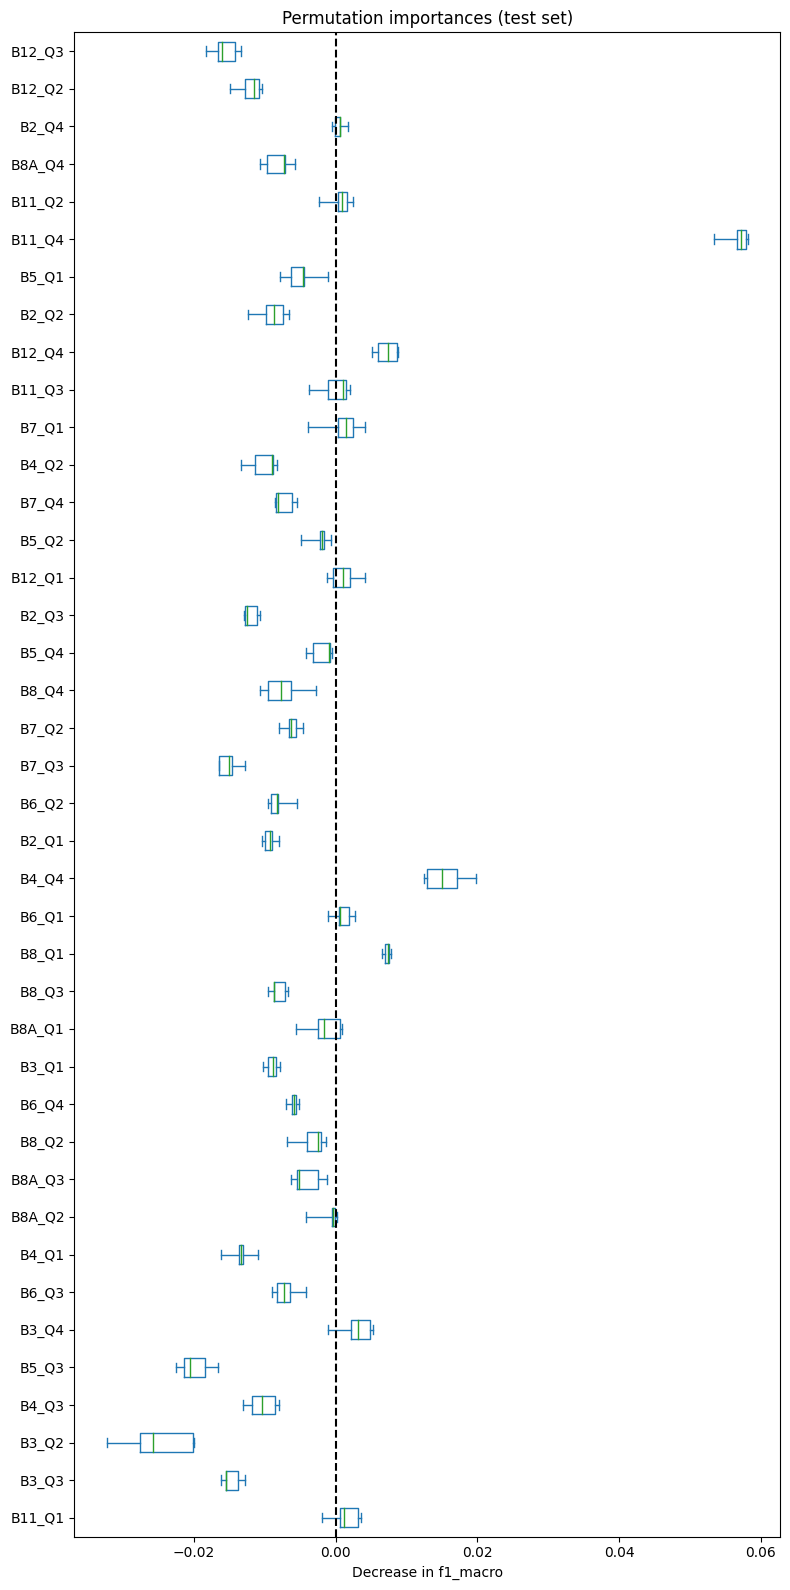

In [57]:
%%time
rf_optimized_train_importances, rf_optimized_test_importances = get_permutation_importances(rf_optimized, X_train, y_train, X_test, y_test)
plot_permutation_importances(rf_optimized_train_importances, rf_optimized_test_importances)

## Convert sklearn classifier object to a list of strings

In [58]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
start_time = time.perf_counter()
trees = ml.rf_to_strings(rf_default, X_train.columns)
end_time = time.perf_counter()
run_time = round((end_time - start_time) / 60, 2)
print('Run time: {} minutes.'.format(run_time))

Run time: 1.27 minutes.


In [59]:
# print the first tree to see the result
print(trees[0])

1) root 2083 9999 9999 (84.67168674836185)
  2) B4_Q3 <= 1331.500000 2083 0.8659 4
    4) B8_Q2 <= 702.500000 155 0.0000 1 *
    5) B8_Q2 > 702.500000 1429 0.8051 8
      10) B12_Q2 <= 1159.250000 1274 0.7694 8
        20) B8A_Q1 <= 2003.750000 486 0.5316 7
          40) B3_Q2 <= 399.750000 109 0.1107 8
            80) B4_Q4 <= 741.500000 4 0.0000 1 *
            81) B4_Q4 > 741.500000 1 0.0000 8 *
          41) B3_Q2 > 399.750000 109 0.1107 8
            82) B12_Q2 <= 662.000000 1 0.0000 1 *
            83) B12_Q2 > 662.000000 103 0.0000 8 *
        21) B8A_Q1 > 2003.750000 486 0.5316 7
          42) B7_Q4 <= 1322.500000 20 0.0000 8 *
          43) B7_Q4 > 1322.500000 377 0.3330 7
            86) B5_Q1 <= 1004.000000 357 0.2590 7
              172) B4_Q2 <= 452.500000 351 0.2309 7
                344) B3_Q2 <= 511.000000 156 0.0254 7
                  688) B8_Q4 <= 1508.000000 152 0.0173 7
                    1376) B5_Q2 <= 736.500000 3 0.0000 7 *
                    1377) B5_Q2 > 736

In [60]:
print(trees[1])

1) root 2092 9999 9999 (84.85210508364258)
  2) B2_Q4 <= 988.250000 2092 0.8643 6
    4) B11_Q2 <= 1014.000000 155 0.0000 1 *
    5) B11_Q2 > 1014.000000 1459 0.8094 6
      10) B8A_Q4 <= 2097.250000 1304 0.7748 6
        20) B5_Q1 <= 892.250000 457 0.4737 8
          40) B7_Q3 <= 1922.500000 250 0.1807 8
            80) B12_Q1 <= 619.500000 158 0.0000 8 *
            81) B12_Q1 > 619.500000 245 0.1474 8
              162) B11_Q2 <= 1319.750000 87 0.3862 8
                324) B8_Q3 <= 1007.250000 1 0.0000 1 *
                325) B8_Q3 > 1007.250000 2 0.0000 7 *
              163) B11_Q2 > 1319.750000 87 0.3862 8
                326) B8_Q4 <= 1853.000000 84 0.3483 8
                  652) B11_Q1 <= 1156.250000 2 0.0000 5 *
                  653) B11_Q1 > 1156.250000 81 0.3178 8
                    1306) B4_Q1 <= 357.250000 79 0.2774 8
                      2612) B2_Q2 <= 228.500000 1 0.0000 1 *
                      2613) B2_Q2 > 228.500000 5 0.4490 7
                        5226) B11

In [61]:
# number of trees we converted should equal the number of trees we defined for the model
n_trees = 100
len(trees) == n_trees

True

## Convert sklearn classifier to GEE classifier

At this point you can take the list of strings and save them locally to avoid training again. However, we want to use the model with EE so we need to create an ee.Classifier and persist the data on ee for best results.

In [62]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [63]:
ee_classifier.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 2083 9999 9999 (84.67168674836185)\n  2) B4_Q3 <= 1331.500000 2083 0.8659 4\n    4) B8_Q2 <= 702.500000 155 0.0000 1 *\n    5) B8_Q2 > 702.500000 1429 0.8051 8\n      10) B12_Q2 <= 1159.250000 1274 0.7694 8\n        20) B8A_Q1 <= 2003.750000 486 0.5316 7\n          40) B3_Q2 <= 399.750000 109 0.1107 8\n            80) B4_Q4 <= 741.500000 4 0.0000 1 *\n            81) B4_Q4 > 741.500000 1 0.0000 8 *\n          41) B3_Q2 > 399.750000 109 0.1107 8\n            82) B12_Q2 <= 662.000000 1 0.0000 1 *\n            83) B12_Q2 > 662.000000 103 0.0000 8 *\n        21) B8A_Q1 > 2003.750000 486 0.5316 7\n          42) B7_Q4 <= 1322.500000 20 0.0000 8 *\n          43) B7_Q4 > 1322.500000 377 0.3330 7\n            86) B5_Q1 <= 1004.000000 357 0.2590 7\n              172) B4_Q2 <= 452.500000 351 0.2309 7\n                344) B3_Q2 <= 511.000000 156 0.0254 7\n                  688) B8_Q4 <= 1508.000000 152 0.0173 7\n               

## Save trees to the cloud

Now we have the strings in a format that ee can use, we want to save it for later use. There is a function to export a list of tree strings to a feature collection.

In [64]:
# specify asset id where to save trees
asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_trees'
asset_id

'projects/ee-alexvmt/assets/mufunta_random_forest_trees'

In [65]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on
# check progress here: https://code.earthengine.google.com/tasks

In [66]:
# save ee classifier to be used in ee directly
classifier_asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_classifier'
task = ee.batch.Export.classifier.toAsset(
    ee_classifier, 'saved classifier', classifier_asset_id
)
task.start()

## Save trees locally

In [67]:
out_csv = os.path.expanduser('models/trees.csv')
ml.trees_to_csv(trees, out_csv)